In [2]:
import netCDF4 as nc

import numpy as np
import torch

import matplotlib.pyplot as plt
from functools import partial

import neuralprocesses.torch as nps
import lab as B

%load_ext autoreload
%autoreload 2

/Users/stratis/repos/neuralprocesses/venv-np/lib/python3.7/site-packages/IPython/extensions/autoreload.py:121: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [17]:
points_per_unit = 1e-4
dim_x = 2
dim_yc = (1, 1)
dim_yt = 2

config = {
    "points_per_unit": 1e-4,
    "dim_x": 2,
    "dim_y": 2,
    "unet_channels": [64] * 6,
    "unet_strides": (1,) + (2,) * 5,
    "conv_channels": 64,
    "num_layers": 6,
    "margin": 1e3,
    "encoder_scales": 1e3,
    "transform": None,
}

root_dir = "/Users/stratis/repos/EnvSensors_WP1/data/antarctica"

generator = nps.AntarcticaGenerator(
    dtype=torch.float32,
    root_dir=root_dir,
#     seed=0,
#     num_tasks=2**14,
#     batch_size=16,
#     num_context_real=UniformDiscrete(50, 200),
#     num_context_sim=UniformDiscrete(50, 200),
#     num_target_real=UniformDiscrete(50, 200),
#     num_target_sim=UniformDiscrete(50, 200),
#     subset="train",
#     mode="both",
    device="cpu",
)

batch = generator.generate_batch()

model = nps.construct_gnp(
    points_per_unit=config["points_per_unit"],
    dim_x=config["dim_x"],
    dim_yc=(1,) * config["dim_y"],
    dim_yt=config["dim_y"],
    likelihood="het",
    conv_arch="unet",
    unet_channels=config["unet_channels"],
    unet_strides=config["unet_strides"],
    conv_channels=config["conv_channels"],
    conv_layers=config["num_layers"],
    margin=config["margin"],
    encoder_scales=config["encoder_scales"],
    transform=config["transform"],
)

state = B.create_random_state(torch.float32, seed=0)

objective = partial(
    nps.loglik,
    num_samples=1,
    normalise=False,
)

state, obj = objective(
    state,
    model,
    batch["contexts"],
    batch["xt"],
    batch["yt"],
    fix_noise=False,
)

print(obj)

torch.Size([16, 2, 18])
torch.Size([16, 1, 18])
torch.Size([16, 2, 15])
torch.Size([16, 1, 15])
torch.Size([16, 2, 30])
torch.Size([16, 1, 30])
torch.Size([16, 2, 25])
torch.Size([16, 1, 25])


NotFoundLookupError: For function "fix_noise", signature Signature(neuralprocesses.dist.normal.MultiOutputNormal[<class 'matrix.matrix.Dense'>, <class 'matrix.constant.Zero'>, <class 'matrix.diagonal.Diagonal'>], builtins.bool) could not be resolved.

In [ ]:
for i in range(20):
    
    batch = generator.generate_batch()

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)

    plt.scatter(
        batch["era5_context_x"][0],
        batch["era5_context_y"][0],
        marker="+",
        color="black"
    )
    plt.scatter(
        batch["era5_target_x"][0],
        batch["era5_target_y"][0],
        marker="+",
        color="red"
    )

    plt.xlim([-5e6, 5e6])
    plt.ylim([-5e6, 5e6])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)

    plt.scatter(
        batch["station_context_x"][0],
        batch["station_context_y"][0],
        marker="+",
        color="black"
    )
    plt.scatter(
        batch["station_target_x"][0],
        batch["station_target_y"][0],
        marker="+",
        color="red"
    )

    plt.xlim([-5e6, 5e6])
    plt.ylim([-5e6, 5e6])
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [223]:
import pandas as pd

station_dir = "/Users/stratis/repos/EnvSensors_WP1/data/antarctica/station/interim"

data = pd.read_csv(f"{station_dir}/all_station_data.csv")
metadata = pd.read_csv(f"{station_dir}/all_station_metadata.csv")

In [98]:
idx = np.argsort(data["date"].values)

In [133]:
t_str = np.unique(data.iloc[idx]["date"].values)[0]

In [134]:
data[data.iloc[idx].date == t_str]

/Users/stratis/repos/neuralprocesses/venv-np/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,station,date,tas,wind_dir,sfcWind,psl,p_station
651621,Macquarie_Island,1948-04-01,5.885714,NaN,NaN,NaN,NaN


/Users/stratis/repos/neuralprocesses/venv-np/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/stratis/repos/neuralprocesses/venv-np/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


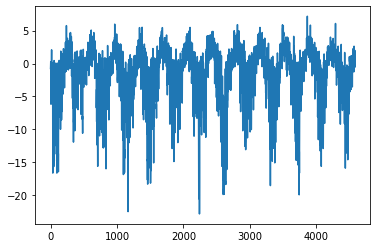

In [158]:
plt.plot(
    np.arange(data[data.iloc[idx].station == "King_Sejong"].tas.shape[0]),
    data[data.iloc[idx].station == "King_Sejong"].tas
)
# plt.xlim([0, 1000])

In [ ]:
np.unique(data.iloc[idx]["station"].values)

In [209]:
ordered_data = data.iloc[idx]
dates = np.unique(ordered_data["date"].values)
numbers = []

for date in dates[:-1:50]:
    
    numbers.append(
        ordered_data[ordered_data["date"] == date].shape[0]
    )

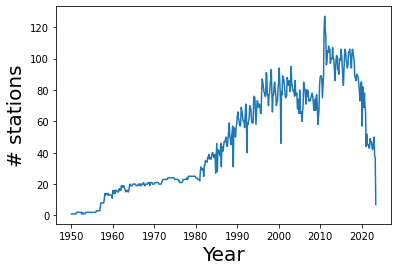

In [219]:
years = 1950 + np.arange(0, dates.shape[0], 50) / 365

plt.plot(years, numbers)

plt.xlabel("Year", fontsize=20)
plt.ylabel("# stations", fontsize=20)
plt.savefig("num-stations.pdf")
plt.show()

In [221]:
pd.Dataframe("all_station_metadata.csv")

,station,date,tas,wind_dir,sfcWind,psl,p_station
0,A028_a_new,1986-02-19,-14.800000,127.500000,11.837500,NaN,NaN
1,A028_a_new,1986-02-22,-12.333333,110.000000,9.671429,NaN,NaN
2,A028_a_new,1986-02-24,-15.926087,135.478261,16.804348,NaN,NaN
3,A028_a_new,1986-02-26,-12.981250,130.375000,9.506250,NaN,NaN
4,A028_a_new,1986-02-27,-11.900000,128.647059,8.976471,NaN,NaN
...,...,...,...,...,...,...,...
1271363,Jubany,1995-12-25,NaN,NaN,NaN,NaN,988.133333
1271364,Marambio,1971-06-25,NaN,NaN,NaN,NaN,971.900000
1271365,Orcadas,1962-07-17,NaN,NaN,NaN,NaN,977.400000
1271366,Orcadas,1962-07-18,NaN,NaN,NaN,NaN,991.875000


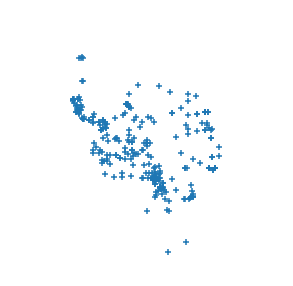

In [235]:
x = metadata["x"].values
y = metadata["y"].values

plt.figure(figsize=(5, 5))
plt.scatter(x, y, marker="+")
plt.xlim([-5e6, 5e6])
plt.ylim([-5e6, 5e6])
plt.axis("off")
plt.show()

In [255]:
data.copy().drop(0, axis=0)

,station,date,tas,wind_dir,sfcWind,psl,p_station
1,A028_a_new,1986-02-22,-12.333333,110.000000,9.671429,NaN,NaN
2,A028_a_new,1986-02-24,-15.926087,135.478261,16.804348,NaN,NaN
3,A028_a_new,1986-02-26,-12.981250,130.375000,9.506250,NaN,NaN
4,A028_a_new,1986-02-27,-11.900000,128.647059,8.976471,NaN,NaN
5,A028_a_new,1986-03-01,-11.811765,116.235294,15.135294,NaN,NaN
...,...,...,...,...,...,...,...
1271363,Jubany,1995-12-25,NaN,NaN,NaN,NaN,988.133333
1271364,Marambio,1971-06-25,NaN,NaN,NaN,NaN,971.900000
1271365,Orcadas,1962-07-17,NaN,NaN,NaN,NaN,977.400000
1271366,Orcadas,1962-07-18,NaN,NaN,NaN,NaN,991.875000


In [264]:
a = data["date"] == "1986-02-19"
a[a].index

Int64Index([      0,   20242,   34421,   59104,   83881,   99456,  121009,
             137657,  157785,  196849,  206362,  223888,  232496,  239810,
             241064,  251152,  274464,  309969,  325611,  376516,  403609,
             413578,  439729,  445804,  464558,  496849,  604491,  610123,
             664315,  671040,  688231,  701894,  740683,  765459,  787251,
             815706,  847650,  879136,  908198,  928363,  943387, 1007827,
            1022993, 1027531, 1041630, 1062644, 1116597, 1184945, 1200823],
           dtype='int64')

In [298]:
metadata

,station,lat,lon,x,y,elev,dem_elev
0,A028_a_new,-68.400000,112.220000,2.219200e+06,-9.065425e+05,1622.0,1587.0
1,A028_b_new,-68.400000,112.220000,2.219200e+06,-9.065425e+05,1622.0,1587.0
2,A028_new,-68.400000,112.220000,2.219200e+06,-9.065425e+05,1622.0,1587.0
3,AGO_A81,-81.500000,3.740000,6.186697e+04,9.464386e+05,2410.0,2365.0
4,AGO_A84,-84.360000,-23.860000,-2.547073e+05,5.758647e+05,2103.0,2035.0
...,...,...,...,...,...,...,...
285,Wilson_Nunatak,-80.039873,-80.557548,-1.095921e+06,1.822629e+05,692.0,661.0
286,Windless Bight,-77.720000,167.690000,2.918228e+05,-1.337299e+06,40.0,22.0
287,Young Island,-66.230000,162.280000,8.018523e+05,-2.509511e+06,30.0,0.0
288,Zhongshan,-69.366667,76.366667,2.226660e+06,5.400571e+05,18.0,0.0


,station,date,tas,wind_dir,sfcWind,psl,p_station
0,A028_a_new,1986-02-19,-14.800000,127.500000,11.837500,NaN,NaN
1,A028_a_new,1986-02-22,-12.333333,110.000000,9.671429,NaN,NaN
2,A028_a_new,1986-02-24,-15.926087,135.478261,16.804348,NaN,NaN
3,A028_a_new,1986-02-26,-12.981250,130.375000,9.506250,NaN,NaN
4,A028_a_new,1986-02-27,-11.900000,128.647059,8.976471,NaN,NaN
...,...,...,...,...,...,...,...
1271363,Jubany,1995-12-25,NaN,NaN,NaN,NaN,988.133333
1271364,Marambio,1971-06-25,NaN,NaN,NaN,NaN,971.900000
1271365,Orcadas,1962-07-17,NaN,NaN,NaN,NaN,977.400000
1271366,Orcadas,1962-07-18,NaN,NaN,NaN,NaN,991.875000


In [331]:
from datetime import timedelta

timedelta(
    days=1
)

datetime.timedelta(days=1)

In [342]:
from datetime import date
date.fromisoformat('2020-02-29').toordinal() - date.fromisoformat('2019-01-01').toordinal()

424

In [101]:
from neuralprocesses.data.gp import GPGenerator
from neuralprocesses.data.sawtooth import SawtoothGenerator
import torch
import numpy as np

In [121]:
generator = GPGenerator(dtype=np.float32, dim_y=2)

In [122]:
batch = generator.generate_batch()

In [166]:
print(
    type(batch["contexts"]),
    len(batch["contexts"]),
)

print(
    type(batch["contexts"][0]),
    len(batch["contexts"][0]),
)

print(
    type(batch["contexts"][0][0]),
    batch["contexts"][0][0].shape,
)

print(
    type(batch["contexts"][0][1]),
    batch["contexts"][0][1].shape,
)

print(
    type(batch["contexts"][1]),
    len(batch["contexts"][1]),
)

print(
    type(batch["contexts"][1][0]),
    batch["contexts"][1][0].shape,
)

print(
    type(batch["contexts"][1][1]),
    batch["contexts"][1][1].shape,
)

<class 'list'> 2
<class 'tuple'> 2
<class 'numpy.ndarray'> (16, 2, 12)
<class 'numpy.ndarray'> (16, 12)
<class 'tuple'> 2
<class 'numpy.ndarray'> (16, 2, 1)
<class 'numpy.ndarray'> (16, 1, 1)


In [114]:
print(
    "\n",
    type(batch["xt"]), "\n",
    type(batch["xt"].elements), "\n",
    len(batch["xt"].elements), "\n",
    type(batch["xt"].elements[0]), "\n",
    len(batch["xt"].elements[0]), "\n",
    type(batch["xt"].elements[0][0]), "\n",
    batch["xt"].elements[0][0].shape, "\n",
)


 <class 'neuralprocesses.aggregate.AggregateInput'> 
 <class 'tuple'> 
 2 
 <class 'tuple'> 
 2 
 <class 'numpy.ndarray'> 
 (16, 1, 50) 



In [115]:
print(
    "\n",
    type(batch["yt"]), "\n",
    type(batch["yt"].elements), "\n",
    len(batch["yt"].elements), "\n",
    type(batch["yt"].elements[0]), "\n",
    batch["yt"].elements[0].shape, "\n",
    type(batch["yt"].elements[1]), "\n",
    batch["yt"].elements[1].shape, "\n",
)


 <class 'neuralprocesses.aggregate.Aggregate'> 
 <class 'tuple'> 
 2 
 <class 'numpy.ndarray'> 
 (16, 1, 50) 
 <class 'numpy.ndarray'> 
 (16, 1, 50) 



In [11]:
import lab as B

B.random.choice(np([1, 2, 3]))

NotFoundLookupError: For function "choice", signature Signature(torch.Tensor) could not be resolved.